# 30x4-fold Cross Validation
#### Comparing the performance of ML classifiers and Consensus strategies

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import run_or_load_joblib
from helper_modules.plotting_metrics import PlotMetric
from helper_modules.friedman_and_nemenyi_test import *

### Load docking results

In [2]:
protein_name = 'cdk2'
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1).values
# Extract the response variable: Activity
y = df_dk_res['activity'].values

X.shape

(3466, 402)

- Compute the proportion of active molecules ($R_a$) of the whole dataset.

In [3]:
R_a = round(y.sum() / len(y), 4)

### Machine Learning Classifiers

#### Dummy Classifier

In [4]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

#### Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 
            'penalty': 'l2', 
            'solver': 'lbfgs', 
            'max_iter':400}
lr = LogisticRegression(**hyparams)

#### Gradient Boosting Trees

In [6]:
from xgboost import XGBClassifier

hyparams = {'subsample': 0.5, 
            'n_estimators': 200, 
            'max_depth': 20, 
            'learning_rate': 0.05,
            'alpha': 0.01,
            'gamma': 0.01, 
            'colsample_bytree': 0.5}
xgb = XGBClassifier(**hyparams)

#### Dictionary of ML classifiers

In [7]:
# ML Classifiers
ml_classifiers = {
    'ml_lr': lr,
    'ml_xgb': xgb,
    'ml_dclf': dclf
}

### Consensus Strategies

In [8]:
from helper_modules.consensus_strategies import \
    get_mean_score, get_min_score, get_geom_mean_score

In [9]:
cs_functions = {
    'cs_MEAN': get_mean_score,
    'cs_GEOM': get_geom_mean_score,
    'cs_MIN': get_min_score
}

### SBVS methods (estimators) dictionary

In [10]:
estimators = {**ml_classifiers, **cs_functions}

In [11]:
# Map new names for each VS method, for plotting
full_names = ['LR', 'GBT', 'DClf', 
              'csAVG', 'csGEO', 'csMIN']
sbvs_names = dict(zip(
    estimators.keys(),
    full_names))
sbvs_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_GEOM': 'csGEO',
 'cs_MIN': 'csMIN'}

### Evaluation metrics

In [12]:
metrics = dict(
    # AUC-ROC
    roc_auc   = {'metric_name': 'roc_auc'},
    # Normalized Enrichment Factor
    nef_12_Ra = {'metric_name': 'ef', 
                 'fraction'   : R_a, 
                 'method'     : 'normalized'}
    )

## 30x4 Cross validation

In [13]:
%run ./1_Helper_functions.ipynb

# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/joelricci/miniconda/envs/mds/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [14]:
# ********************
# Perform the 30x4 CV
# ********************

n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename = f'./cachedir/{evaluation_name}_{protein_name}',
    estimators = estimators, 
    X = X,
    y = y, 
    metrics = metrics, 
    n_repeats = n_repeats, n_splits=n_splits,
    y_preds_return = True,
    random_state = 42
)

# Rename columns 
cv30x4 = cv30x4.rename(columns = sbvs_names)



File loaded: ./cachedir/30x4cv_cdk2


### AUC-ROC Results

In [15]:
# **********************
# Descriptive Statistics
# **********************

# ROC-AUC
metric_name='roc_auc'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]

# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csMIN,csAVG,csGEO,LR,GBT
medians,0.49819,0.56482,0.63652,0.63712,0.89223,0.90977


IQRs:


,DClf,csMIN,csAVG,csGEO,LR,GBT
IQRs,0.021365,0.044845,0.041765,0.04179,0.018455,0.023535


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,0,1,0,0,0


Friedman Test:


,chi^2,dof,p_value
Friedman Test,591.514286,5,1.378073e-125


In [16]:
# **********************************
# Extract the individual predictions
# **********************************
# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(
                            X, y, 
                            metrics[metric_name], 
                            n_reps = n_repeats, 
                            test_size = 0.5, 
                            random_state = 42
                           )

<p style='color: black; background-color: #F9E5AB; padding: 5px;'>
    We will use <b>R</b> for plotting
</p>

In [17]:
%load_ext rpy2.ipython

In [18]:
%%R
full_names <- c('LR', 'GBT', 'DClf', 
                'csAVG', 'csGEO', 'csMIN')
cbbPalette <- c('#785EF0', '#3F93D2', '#44AA99', 
                '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to c

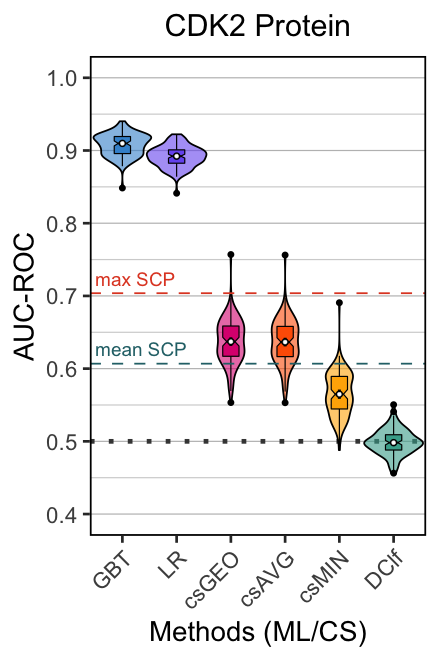

In [19]:
%%R  -i df_R -i single_mean -i single_max -w 2.2 -h 3.3 --units in -r 200

source('../R_scripts/plot_violinBox.R')

p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.4, y_max=1,
                dot_size = 4, scale='area', 
                violin_width=1.1) +
add_ref_values('mean SCP', single_mean, 
               color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, 
               color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

p

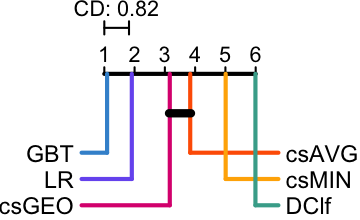

In [20]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200

source('../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)

plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



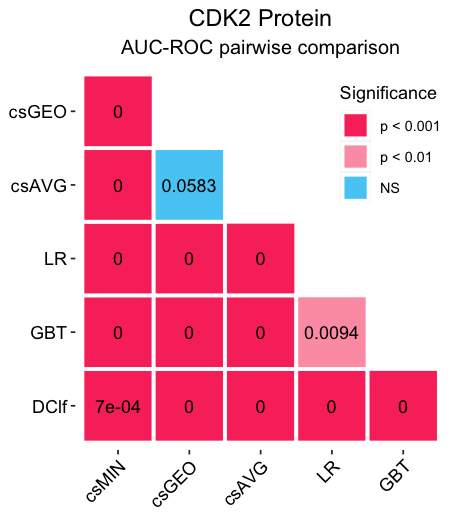

In [21]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title = 'CDK2 Protein', 
     subtitle="AUC-ROC pairwise comparison")
p

### NEF Results

In [22]:
# **********************
# Descriptive Statistics
# **********************

# NEF
metric_name='nef_12_Ra'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]

# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csMIN,csAVG,csGEO,LR,GBT
medians,0.11538,0.20388,0.3301,0.3301,0.56731,0.64423


IQRs:


,DClf,csMIN,csAVG,csGEO,LR,GBT
IQRs,0.053115,0.04238,0.05769,0.05769,0.03846,0.05452


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,0,1,0,0,1


Friedman Test:


,chi^2,dof,p_value
Friedman Test,577.72619,5,1.312221e-122


In [23]:
# **********************************
# Extract the individual predictions
# **********************************
# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(
                            X, y, 
                            metrics[metric_name], 
                            n_reps = n_repeats, 
                            test_size = 0.5, 
                            random_state = 42
                           )

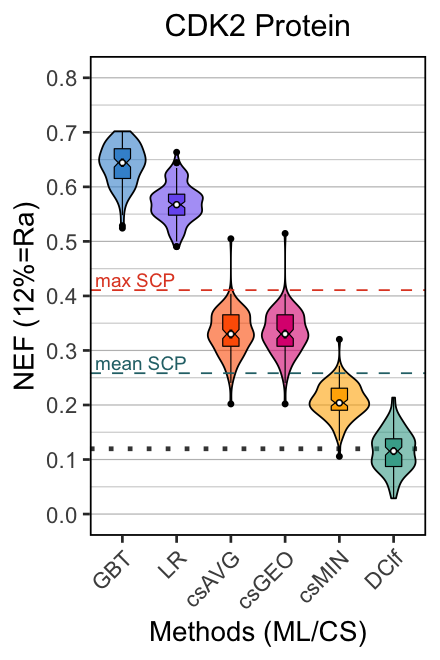

In [24]:
%%R  -i df_R -i single_mean -i single_max -i R_a -w 2.2 -h 3.3 --units in -r 200

source('../R_scripts/plot_violinBox.R')

p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.0, y_max=0.8,
                dot_size = 4, scale='area', 
                violin_width=1.1, 
                base_h_line=R_a,
                y_label='NEF (12%=Ra)') +
add_ref_values('mean SCP', single_mean, 
               color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, 
               color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('CDK2 Protein')

p

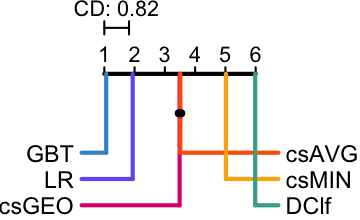

In [25]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200

source('../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)

plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)

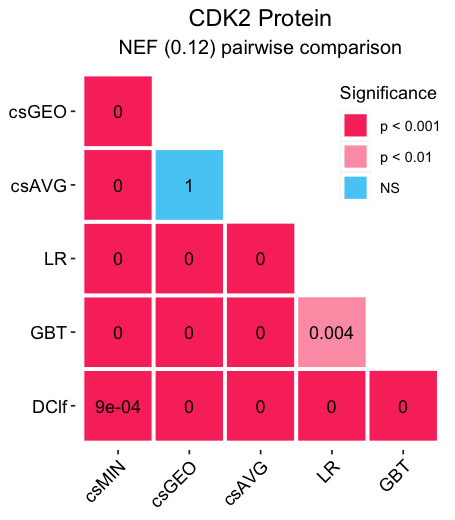

In [26]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)

p = plot_p_vals_heatmap(df_R) +
labs(title = 'CDK2 Protein', 
     subtitle = "NEF (0.12) pairwise comparison")
p

Finished!